In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlops_rakuten.config.constants import RAKUTEN_DATA_DIR

2025-12-14 11:44:18.406 | INFO     | mlops_rakuten.config.constants:<module>:11 - PROJ_ROOT path is: /Users/julientherier/Developer/DataScientest/Projets/nov25cmlops_rakuten
2025-12-14 11:44:18.407 | INFO     | mlops_rakuten.config.constants:<module>:31 - RAW_DATA_DIR is /Users/julientherier/Developer/DataScientest/Projets/nov25cmlops_rakuten/data/raw
2025-12-14 11:44:18.408 | INFO     | mlops_rakuten.config.constants:<module>:32 - MODULE_DIR is /Users/julientherier/Developer/DataScientest/Projets/nov25cmlops_rakuten/mlops_rakuten
2025-12-14 11:44:18.408 | INFO     | mlops_rakuten.config.constants:<module>:33 - MODELS_DIR is /Users/julientherier/Developer/DataScientest/Projets/nov25cmlops_rakuten/models


In [4]:
print("Fichiers disponibles:")
print("*****************")
print("Fichiers texte :")
if RAKUTEN_DATA_DIR.exists():
    for f in sorted(RAKUTEN_DATA_DIR.glob('*.csv')):
        size_mb = f.stat().st_size / 1024 / 1024
        print(f"  {f.name}: {size_mb:.1f} MB")
print("*****************")

Fichiers disponibles:
*****************
Fichiers texte :
  X_train_update.csv: 51.6 MB
  Y_train_CVw08PX.csv: 0.9 MB
*****************


In [5]:
X_train = pd.read_csv(RAKUTEN_DATA_DIR / 'X_train_update.csv')
Y_train = pd.read_csv(RAKUTEN_DATA_DIR / 'Y_train_CVw08PX.csv')


dfs = {
    "X_train": X_train,
    "Y_train": Y_train,
}

print(f"Train: {X_train.shape}")

print(f" Classes: {Y_train['prdtypecode'].nunique()} catégories\n")

# Aperçu des données
print("Schéma des données:")
print(X_train.columns)
print(Y_train.columns)

for name, df in dfs.items():
    print(f"\n{name}:")
    for col in df.columns:
        print(f"  - {col}: {df[col].dtype}")

Train: (84916, 5)
 Classes: 27 catégories

Schéma des données:
Index(['Unnamed: 0', 'designation', 'description', 'productid', 'imageid'], dtype='object')
Index(['Unnamed: 0', 'prdtypecode'], dtype='object')

X_train:
  - Unnamed: 0: int64
  - designation: object
  - description: object
  - productid: int64
  - imageid: int64

Y_train:
  - Unnamed: 0: int64
  - prdtypecode: int64


In [6]:
train_data = X_train.merge(
    Y_train,
    left_on=X_train.columns[0],  # Première colonne = index
    right_on=Y_train.columns[0]
)

# Afficher dimensions
print(f"train_data: {train_data.shape}")

# Aperçu des premières lignes
train_data.head()

train_data: (84916, 6)


,Unnamed: 0,designation,description,productid,imageid,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


In [7]:
# Compter les classes
class_counts = train_data.groupby('prdtypecode').size().reset_index(
    name='count').sort_values(by='count', ascending=False)

print(f" Nombre de classes uniques: {len(class_counts)}")
print(f"Distribution:")
print(class_counts.head(15))

# Stats basiques
counts = class_counts['count'].to_numpy()
print(f"\n Statistiques classes:")
print(f"  Min samples: {counts.min()}")
print(f"  Max samples: {counts.max()}")
print(f"  Mean: {counts.mean():.1f}")
print(f"  Median: {np.median(counts):.1f}")
print(f"  Std: {counts.std():.1f}")
print(f"  Ratio max/min: {counts.max()/counts.min():.1f}x")

# Déséquilibre?
if counts.max() / counts.min() > 10:
    print("\n  DATASET TRÈS DÉSÉQUILIBRÉ")

 Nombre de classes uniques: 27
Distribution:
    prdtypecode  count
23         2583  10209
13         1560   5073
9          1300   5045
16         2060   4993
21         2522   4989
7          1280   4870
19         2403   4774
18         2280   4760
14         1920   4303
5          1160   3953
12         1320   3241
0            10   3116
25         2705   2761
4          1140   2671
22         2582   2589

 Statistiques classes:
  Min samples: 764
  Max samples: 10209
  Mean: 3145.0
  Median: 2671.0
  Std: 2063.9
  Ratio max/min: 13.4x

  DATASET TRÈS DÉSÉQUILIBRÉ


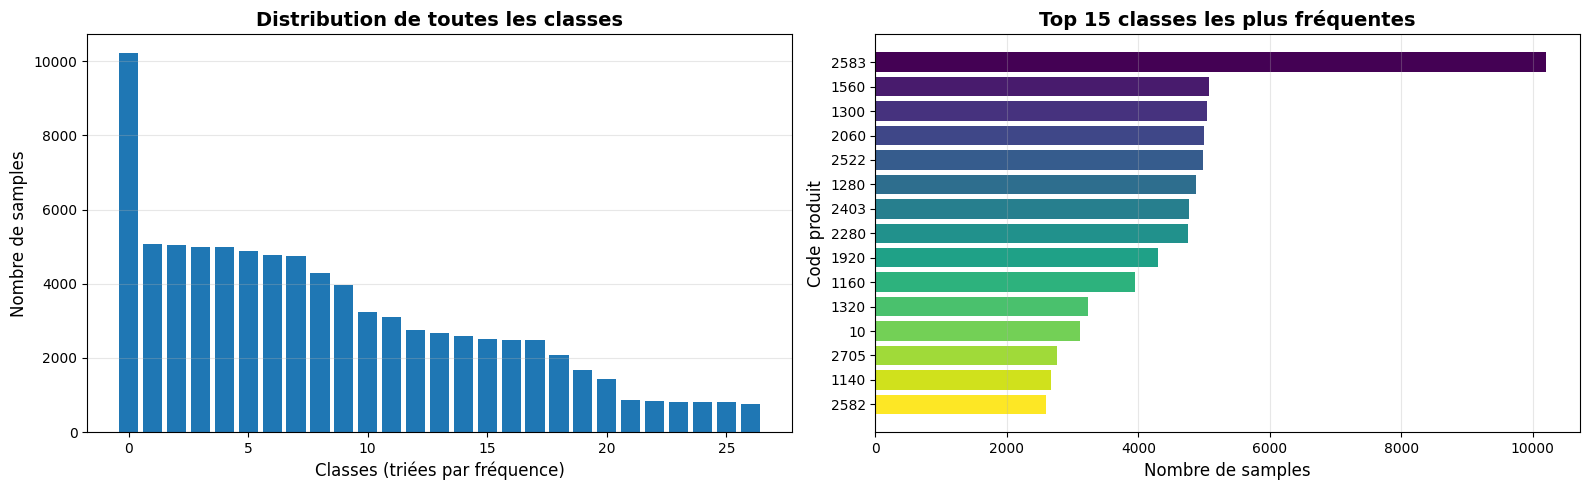

In [8]:
# Barplot distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Toutes les classes
ax1 = axes[0]

ax1.bar(range(len(class_counts)), class_counts['count'])
ax1.set_xlabel('Classes (triées par fréquence)', fontsize=12)
ax1.set_ylabel('Nombre de samples', fontsize=12)
ax1.set_title('Distribution de toutes les classes',
              fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Top 15 classes
ax2 = axes[1]
top_15 = class_counts.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
ax2.barh(top_15['prdtypecode'].astype(str), top_15['count'], color=colors)
ax2.set_xlabel('Nombre de samples', fontsize=12)
ax2.set_ylabel('Code produit', fontsize=12)
ax2.set_title('Top 15 classes les plus fréquentes',
              fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
def analyse_colonnes(df, colonnes):
    for col in colonnes:
        print("=" * 80)
        print(f"STATISTIQUES - {col}")
        print("=" * 80)

        # Copie pour éviter les warnings
        stats = df.copy()

        # Colonnes dérivées
        stats[f'{col}_missing'] = stats[col].isnull()
        stats[f'{col}_len'] = stats[col].dropna().apply(len)
        stats[f'{col}_words'] = stats[col].dropna().apply(
            lambda x: len(x.split()))

        # Taux de remplissage
        missing_pct = stats[f'{col}_missing'].mean() * 100
        print(f"{col} manquantes: {missing_pct:.1f}%")

        # Stats descriptives
        col_len = stats.loc[~stats[f'{col}_missing'], f'{col}_len'].to_numpy()
        col_words = stats.loc[~stats[f'{col}_missing'],
                              f'{col}_words'].to_numpy()

        if len(col_len) > 0:
            print(f"\n Stats longueur {col}:")
            print(f"  Count: {len(col_len)}")
            print(f"  Min: {col_len.min()}")
            print(f"  Max: {col_len.max()}")
            print(f"  Mean: {col_len.mean():.1f}")
            print(f"  Median: {np.median(col_len):.1f}")
            print(f"  Std: {col_len.std():.1f}")

            # Histogramme
            fig, ax = plt.subplots(figsize=(12, 5))
            ax.hist(col_len, bins=50, edgecolor='black', alpha=0.7)
            ax.axvline(np.mean(col_len), color='red', linestyle='--',
                       label=f'Moyenne: {np.mean(col_len):.1f}')
            ax.set_xlabel('Longueur (caractères)', fontsize=12)
            ax.set_ylabel('Fréquence', fontsize=12)
            ax.set_title(
                f'Distribution longueur {col}', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
            plt.show()

        # Exemples
        print(f"\n Exemples de {col}:")
        with_col = stats.loc[~stats[f'{col}_missing'], col].head(3)
        for val in with_col:
            print(f"  {val}")

STATISTIQUES - designation
designation manquantes: 0.0%

 Stats longueur designation:
  Count: 84916
  Min: 11
  Max: 250
  Mean: 70.2
  Median: 64.0
  Std: 36.8


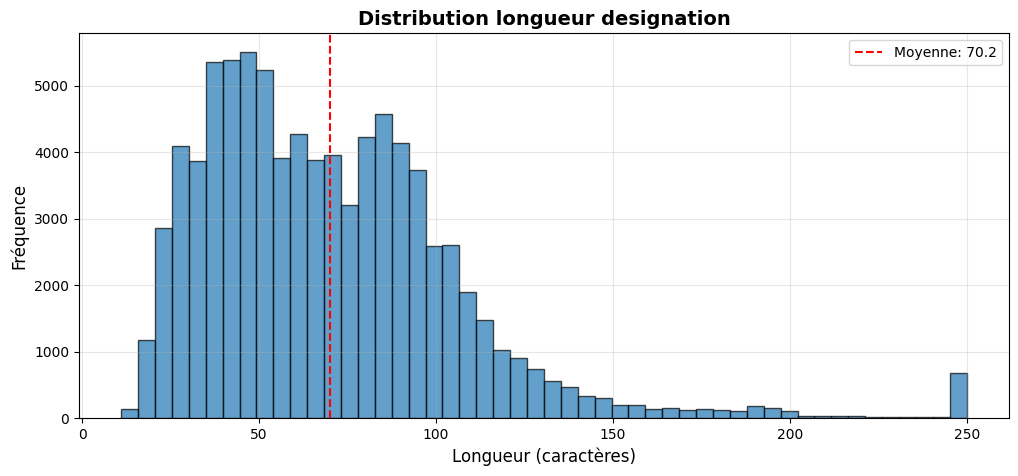


 Exemples de designation:
  Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design
  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.
  Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style
STATISTIQUES - description
description manquantes: 35.1%

 Stats longueur description:
  Count: 55116
  Min: 1.0
  Max: 12451.0
  Mean: 808.2
  Median: 626.0
  Std: 805.5


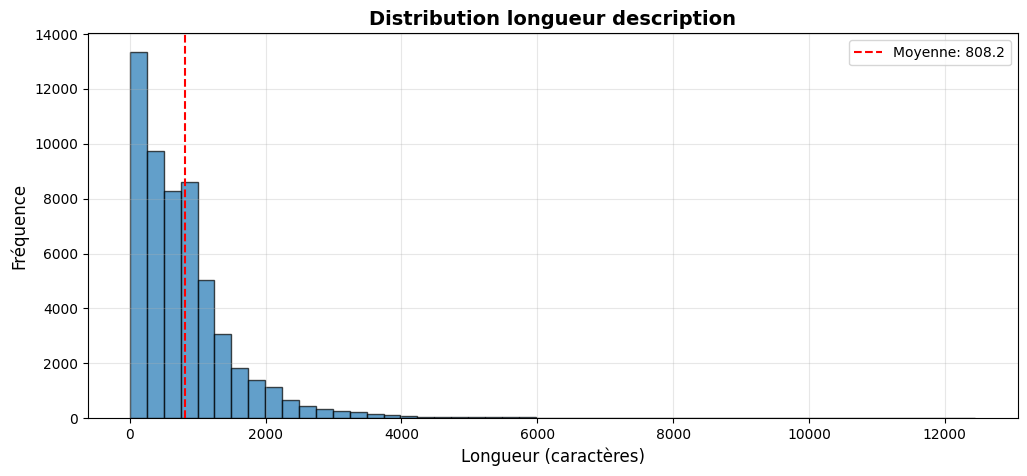


 Exemples de description:
  PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class="vga_style2"><b></b><br>
  Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses pla

In [10]:
# Analyser les colonnes textuelles
analyse_colonnes(train_data, ["designation", "description"])

In [11]:
duplicates = (
    train_data.groupby("designation")
    .agg(
        count=("designation", "size"),
        unique_categories=("prdtypecode", "nunique"),
        unique_descriptions=("description", "nunique"),
    )
    .reset_index()
)

duplicates = duplicates[duplicates["count"] >
                        1].sort_values("count", ascending=False)

print("="*70)
print(" VUE D'ENSEMBLE")
print("="*70)
print(f"Total désignations dupliquées: {len(duplicates):,}")
print(
    f"Doublons avec descriptions identiques: {len(duplicates[duplicates['unique_descriptions'] == 1]):,}")
print(
    f"Doublons avec descriptions différentes: {len(duplicates[duplicates['unique_descriptions'] > 1]):,}")
print()

 VUE D'ENSEMBLE
Total désignations dupliquées: 1,422
Doublons avec descriptions identiques: 609
Doublons avec descriptions différentes: 738



In [12]:
# Identifier les doublons
duplicates = (
    train_data
    .groupby("designation")
    .agg(
        count=("designation", "size"),
        unique_categories=("prdtypecode", "nunique"),
        unique_descriptions=("description", "nunique"),
    )
    .reset_index()
)

# Ne garder que les désignations présentes plusieurs fois
duplicates = duplicates[duplicates["count"] >
                        1].sort_values("count", ascending=False)

print(f"{'='*70}")
print(f"VUE D'ENSEMBLE - DOUBLONS")
print(f"{'='*70}")

# Stats globales
print(f"\n Statistiques Globales:")
print(f"   Total désignations dupliquées:         {len(duplicates):,}")
print(
    f"   Produits concernés (total):            {duplicates['count'].sum():,}")

# Par descriptions
print(f"\n Par Descriptions:")
print(
    f"   Descriptions identiques:               {len(duplicates[duplicates['unique_descriptions'] == 1]):,}")
print(
    f"   Descriptions différentes:              {len(duplicates[duplicates['unique_descriptions'] > 1]):,}")

# Par catégories
print(f"\n  Par Catégories:")
print(
    f"   Catégories identiques:                 {len(duplicates[duplicates['unique_categories'] == 1]):,}")
print(
    f"   Catégories différentes (CONFLITS):     {len(duplicates[duplicates['unique_categories'] > 1]):,}")

# Matrice croisée
print(f"\n Matrice Croisée (Descriptions × Catégories):")
print(f"{'':40s} {'Cat=1':>15s} {'Cat>1':>15s} {'Total':>15s}")
print(f"{'-'*70}")

desc_1_cat_1 = len(duplicates[(duplicates['unique_descriptions'] == 1) & (
    duplicates['unique_categories'] == 1)])
desc_1_cat_n = len(duplicates[(duplicates['unique_descriptions'] == 1) & (
    duplicates['unique_categories'] > 1)])
desc_n_cat_1 = len(duplicates[(duplicates['unique_descriptions'] > 1) & (
    duplicates['unique_categories'] == 1)])
desc_n_cat_n = len(duplicates[(duplicates['unique_descriptions'] > 1) & (
    duplicates['unique_categories'] > 1)])

desc_1_total = desc_1_cat_1 + desc_1_cat_n
desc_n_total = desc_n_cat_1 + desc_n_cat_n

print(f"{'Desc identiques (=1)':40s} {desc_1_cat_1:>15,} {desc_1_cat_n:>15,} {desc_1_total:>15,}")
print(f"{'Desc différentes (>1)':40s} {desc_n_cat_1:>15,} {desc_n_cat_n:>15,} {desc_n_total:>15,}")
print(f"{'-'*70}")
print(f"{'Total':40s} {desc_1_cat_1 + desc_n_cat_1:>15,} {desc_1_cat_n + desc_n_cat_n:>15,} {len(duplicates):>15,}")

# Pourcentages
print(f"\n Proportions:")
if len(duplicates) > 0:
    print(
        f"   Cas problématiques (Desc=1, Cat>1):   {desc_1_cat_n:>6,} ({desc_1_cat_n/len(duplicates)*100:>5.1f}%)")
    print(
        f"   Variantes légitimes (Desc>1, Cat=1):  {desc_n_cat_1:>6,} ({desc_n_cat_1/len(duplicates)*100:>5.1f}%)")
    print(
        f"   Ambiguïtés (Desc>1, Cat>1):           {desc_n_cat_n:>6,} ({desc_n_cat_n/len(duplicates)*100:>5.1f}%)")
    print(
        f"   Parfaits doublons (Desc=1, Cat=1):    {desc_1_cat_1:>6,} ({desc_1_cat_1/len(duplicates)*100:>5.1f}%)")

print(f"\n{'='*70}\n")

VUE D'ENSEMBLE - DOUBLONS

 Statistiques Globales:
   Total désignations dupliquées:         1,422
   Produits concernés (total):            4,073

 Par Descriptions:
   Descriptions identiques:               609
   Descriptions différentes:              738

  Par Catégories:
   Catégories identiques:                 1,277
   Catégories différentes (CONFLITS):     145

 Matrice Croisée (Descriptions × Catégories):
                                                   Cat=1           Cat>1           Total
----------------------------------------------------------------------
Desc identiques (=1)                                 587              22             609
Desc différentes (>1)                                617             121             738
----------------------------------------------------------------------
Total                                              1,204             143           1,422

 Proportions:
   Cas problématiques (Desc=1, Cat>1):       22 (  1.5%)
   Variante